# Tomography imquant example notebook
This notebook is an example to be used with the "Tomography / Imquant / GPU" kernel.

### Most Recent Update
What follows is a shorter, altered version of what is in https://github.com/tomograms/tomography-notebooks/blob/rajmund/imquant_foam.ipynb

# Load libraries 
for image processing we use skimage, for saving results pandas

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from skimage.io import imread, imsave
from glob import glob
import matplotlib.pyplot as plt

# Read in data
in this case a 3D tif stack of tomographic slices

In [2]:
# Set the data path
site_data_dir = '/mxn/groups/kits/scisw/jupyterhub/data-for-validations/tomography/imquant' # tomograms test data at MAX IV
print("Site data root directory: %s" % site_data_dir)

Site data root directory: /mxn/groups/kits/scisw/jupyterhub/data-for-validations/tomography/imquant


In [3]:
all_files = sorted(glob(site_data_dir+'/sample1_mid*stack.tif'))
print('Number of files:', len(all_files))
for file in all_files:
    print('  ', file)

Number of files: 1
   /mxn/groups/kits/scisw/jupyterhub/data-for-validations/tomography/imquant/sample1_mid_1h_stack.tif


In [4]:
stack_image = imread(all_files[0])

In [5]:
nhight, ncols, nrows = stack_image.shape
row, col = np.ogrid[:nrows, :ncols]
print(stack_image.shape, stack_image.dtype)

(1152, 1600, 1600) uint8


## (Optional) image-stack crop

Running this notebook on the full stack of example images may require large (~ 100 GB)
amount of memmory. You can downscale this requirements by working on smaller dataset.

In [6]:
# (optional) crop image stack
crop_imstack = True

if crop_imstack:
    stack_image = stack_image[:nhight//4,:,:]
    print('Cropped image-stack:')
    nhight, ncols, nrows = stack_image.shape
    row, col = np.ogrid[:nrows, :ncols]
    print(stack_image.shape, stack_image.dtype)

Cropped image-stack:
(288, 1600, 1600) uint8


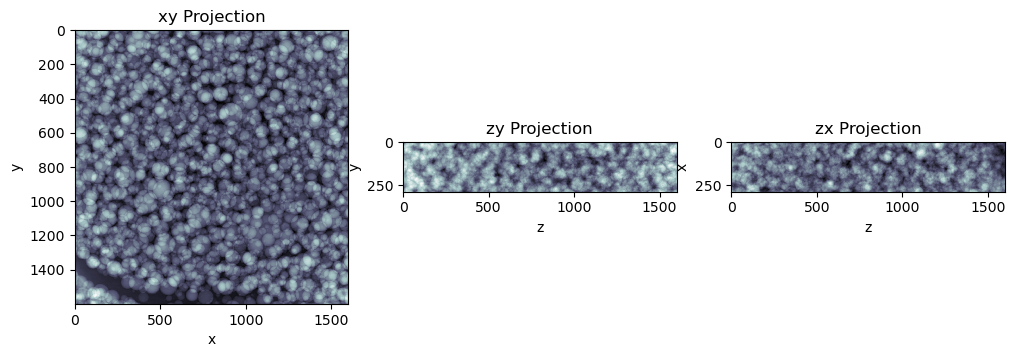

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
for i, (cax, clabel) in enumerate(zip([ax1, ax2, ax3], ['xy', 'zy', 'zx'])):
    cax.imshow(np.sum(stack_image,i).squeeze(), interpolation='none', cmap = 'bone_r')
    cax.set_title('%s Projection' % clabel)
    cax.set_xlabel(clabel[0])
    cax.set_ylabel(clabel[1])

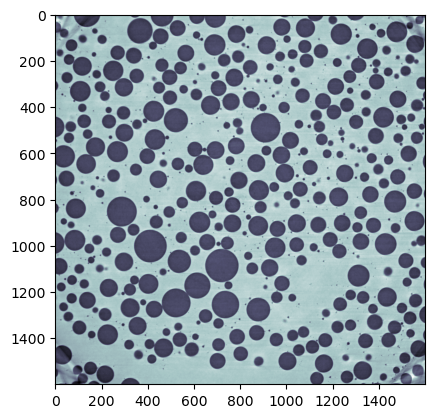

In [8]:
plt.imshow(stack_image[100], cmap='bone')

# Binarization

First remove extreme values from the image

In [9]:
# note: there is a slower alternative in scipy.stats
vmin, vmax = np.percentile(stack_image, (0.5, 99.5))
vmin = vmin.astype(np.uint8)
vmax = vmax.astype(np.uint8)

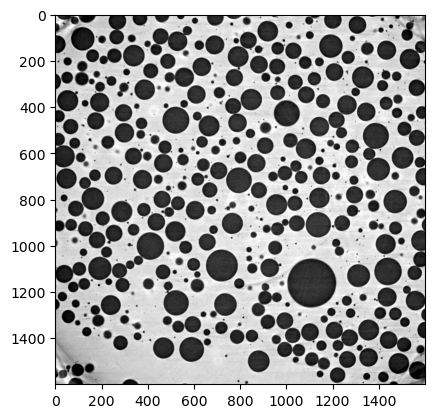

In [10]:
np.clip(stack_image, vmin, vmax, out=stack_image)
stack_image = (stack_image - np.float32(vmin)) / np.float32(vmax - vmin)
plt.imshow(stack_image[60], cmap='gray')

## Simple thresholding

In [11]:
from skimage import exposure
hi_stack_image = exposure.histogram(stack_image)

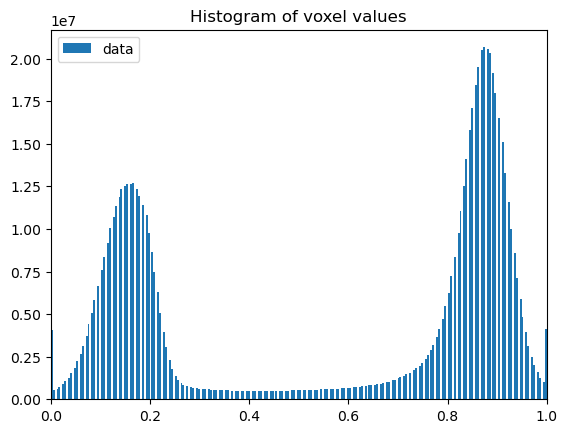

In [12]:
plt.bar(hi_stack_image[1],hi_stack_image[0],width=hi_stack_image[1][1]-hi_stack_image[1][0],label='data')
plt.xlim(0, 1)
plt.legend()
plt.title('Histogram of voxel values');

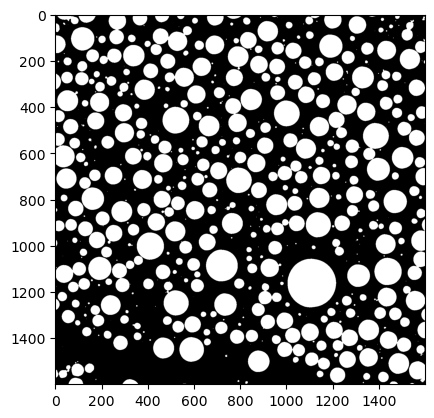

In [13]:
seg_stack_image = stack_image > 0.4
seg_stack_image_inv = np.invert(seg_stack_image)
plt.imshow(seg_stack_image_inv[60],cmap='gray')

## Random walker segmentation

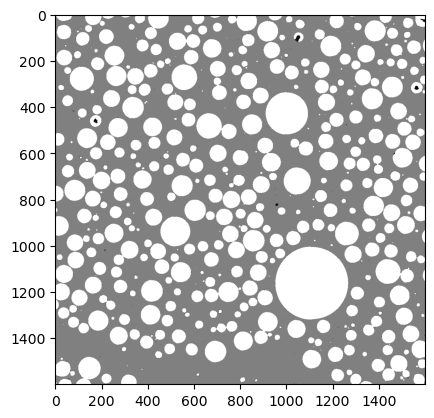

In [14]:
markers = np.zeros(stack_image.shape, dtype=np.uint8)
markers[stack_image > 0.4] = 1
markers[stack_image < 0.33] = 2
plt.imshow(markers[10], cmap='gray')